In [ ]:
# Cell 1: Environment Setup for Comparative Experiment
# Purpose: Install SSH library and import tools for multi-VPS communication

!pip install paramiko -q

import paramiko
import re
import sys
import pandas as pd
from google.colab import userdata

print("✅ Step 1 Complete: Environment is ready for multi-VPS analysis.")
print(f"Python: {sys.version.split()[0]} | Paramiko: {paramiko.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.9/223.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.3/160.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.2 MB/s eta 0:00:00
✅ Step 1 Complete: Environment is ready for multi-VPS analysis.
Python: 3.12.12 | Paramiko: 4.0.0


In [ ]:
# Cell 2: Triple VPS Configuration
# Purpose: Securely load credentials for VPS1, VPS2, and VPS3

from google.colab import userdata

try:
    # Router 1
    vps1_auth = {
        "host": userdata.get('VPS1_HOST'),
        "user": userdata.get('VPS1_USERNAME'),
        "pass": userdata.get('VPS1_PASSWORD')
    }

    # Router 2
    vps2_auth = {
        "host": userdata.get('VPS2_HOST'),
        "user": userdata.get('VPS2_USERNAME'),
        "pass": userdata.get('VPS2_PASSWORD')
    }

    # Router 3
    vps3_auth = {
        "host": userdata.get('VPS3_HOST'),
        "user": userdata.get('VPS3_USERNAME'),
        "pass": userdata.get('VPS3_PASSWORD')
    }

    # Standard path for peer profiles across all instances
    PROFILES_PATH = "/home/sid/.i2p/peerProfiles"

    # Verification check
    configs = [vps1_auth, vps2_auth, vps3_auth]
    if all(all(c.values()) for c in configs):
        print("✅ Credentials for VPS1, VPS2, and VPS3 loaded successfully.")
        print(f"Targeting: {PROFILES_PATH} on all nodes.")
    else:
        print("❌ Error: One or more secrets are missing for your 3-node cluster.")

except Exception as e:
    print(f"❌ Error accessing secrets: {e}")

✅ Credentials for VPS1, VPS2, and VPS3 loaded successfully.
Targeting: /home/sid/.i2p/peerProfiles on all nodes.


In [ ]:
# Cell 3: Multi-Node Connection Establishment
# Purpose: Connect to VPS1, VPS2, and VPS3 and verify data accessibility

vps_clients = {}
vps_configs = {
    "VPS1": vps1_auth,
    "VPS2": vps2_auth,
    "VPS3": vps3_auth
}

for name, config in vps_configs.items():
    try:
        print(f"Connecting to {name} ({config['host']})...")
        client = paramiko.SSHClient()
        client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        client.connect(
            hostname=config['host'],
            username=config['user'],
            password=config['pass'],
            timeout=15
        )

        # Verify directory existence
        stdin, stdout, stderr = client.exec_command(f"ls -d {PROFILES_PATH}")
        if stdout.channel.recv_exit_status() == 0:
            print(f"✅ {name}: Connected and directory verified.")
            vps_clients[name] = client
        else:
            print(f"❌ {name}: Connected, but {PROFILES_PATH} not found.")
            client.close()

    except Exception as e:
        print(f"❌ {name}: Connection failed - {e}")

if len(vps_clients) == 3:
    print("\n🚀 All three nodes are ready for the comparison experiment.")
else:
    print(f"\n⚠️ Only {len(vps_clients)}/3 nodes are ready. Please check the failures above.")

Connecting to VPS1 (107.175.145.4)...
✅ VPS1: Connected and directory verified.
Connecting to VPS2 (107.172.250.117)...
✅ VPS2: Connected and directory verified.
Connecting to VPS3 (104.168.77.85)...
✅ VPS3: Connected and directory verified.

🚀 All three nodes are ready for the comparison experiment.


In [7]:
# Cell 4: Extract I2P Peer Data from All VPS
# Purpose: Fetch profiles from port 7657 and save raw data

import time
from bs4 import BeautifulSoup
import re

print("="*80)
print("CELL 4: EXTRACT I2P PEER DATA")
print("="*80)

# Dictionary to store all peers
all_peers = []

# Extract from each VPS
for vps_name, client in vps_clients.items():
    print(f"\n📡 Connecting to {vps_name}...")

    try:
        # Fetch profiles page
        cmd = "curl -L -s -m 60 http://127.0.0.1:7657/profiles?f=1 2>/dev/null"
        stdin, stdout, stderr = client.exec_command(cmd, timeout=65)

        html_content = stdout.read().decode('utf-8', errors='ignore')

        # Verify we got HTML
        if not html_content or '<table' not in html_content:
            print(f"   ❌ ERROR: No valid HTML from {vps_name}")
            continue

        print(f"   ✅ Received {len(html_content)} bytes of HTML")

        # Parse HTML table
        soup = BeautifulSoup(html_content, 'html.parser')
        tables = soup.find_all('table')

        if not tables:
            print(f"   ❌ No tables found in HTML")
            continue

        # Get the main table (largest one)
        target_table = max(tables, key=lambda t: len(t.find_all('tr')))
        rows = target_table.find_all('tr')

        print(f"   📊 Found table with {len(rows)} rows")

        # Extract header
        header_cells = rows[0].find_all(['th', 'td'])
        headers = [cell.get_text(strip=True) for cell in header_cells]

        # Find column indices
        peer_idx = next((i for i, h in enumerate(headers) if 'Peer' in h), None)
        group_idx = next((i for i, h in enumerate(headers) if 'Group' in h), None)
        speed_idx = next((i for i, h in enumerate(headers) if 'Speed' in h), None)

        if None in [peer_idx, group_idx, speed_idx]:
            print(f"   ❌ Missing columns: Peer={peer_idx}, Group={group_idx}, Speed={speed_idx}")
            continue

        print(f"   ✓ Column indices: Peer={peer_idx}, Group={group_idx}, Speed={speed_idx}")

        # Extract peers from data rows
        peer_count = 0
        for row in rows[1:]:
            cells = row.find_all('td')

            if len(cells) <= max(peer_idx, group_idx, speed_idx):
                continue

            try:
                # Get Peer ID
                peer_text = cells[peer_idx].get_text(strip=True)
                peer_id = peer_text.split()[0] if peer_text else None

                if not peer_id or len(peer_id) < 3:
                    continue

                # Get Group
                group_text = cells[group_idx].get_text(strip=True)

                # Get Speed
                speed_text = cells[speed_idx].get_text(strip=True)
                speed_match = re.search(r'(\d+\.?\d*)', speed_text)
                speed = float(speed_match.group(1)) if speed_match else 0.0

                # Store data
                all_peers.append({
                    'Peer_ID': peer_id,
                    'Group_Raw': group_text,
                    'Speed': speed,
                    'VPS': vps_name
                })

                peer_count += 1

            except Exception as e:
                continue

        print(f"   ✅ Extracted {peer_count} peers from {vps_name}")

    except Exception as e:
        print(f"   ❌ ERROR: {e}")
        continue

    time.sleep(2)

# Create DataFrame
print(f"\n{'='*80}")
print(f"RESULTS")
print(f"{'='*80}")

if all_peers:
    df_raw = pd.DataFrame(all_peers)
    print(f"\n✅ Total peers extracted: {len(df_raw)}")
    print(f"   VPS1: {len(df_raw[df_raw['VPS']=='VPS1'])}")
    print(f"   VPS2: {len(df_raw[df_raw['VPS']=='VPS2'])}")
    print(f"   VPS3: {len(df_raw[df_raw['VPS']=='VPS3'])}")

    # Save to CSV (with raw group for now)
    df_raw.to_csv('i2p_peers_raw.csv', index=False)
    print(f"\n✅ Saved: i2p_peers_raw.csv")

    print(f"\nSample data (first 10 rows):")
    print(df_raw.head(10).to_string())

else:
    print(f"\n❌ No peers extracted. Check SSH connections and I2P status.")

CELL 4: EXTRACT I2P PEER DATA

📡 Connecting to VPS1...
   ✅ Received 4822359 bytes of HTML
   📊 Found table with 7728 rows
   ✓ Column indices: Peer=0, Group=1, Speed=4
   ✅ Extracted 7725 peers from VPS1

📡 Connecting to VPS2...
   ✅ Received 4851797 bytes of HTML
   📊 Found table with 7769 rows
   ✓ Column indices: Peer=0, Group=1, Speed=4
   ✅ Extracted 7766 peers from VPS2

📡 Connecting to VPS3...
   ✅ Received 3386667 bytes of HTML
   📊 Found table with 5436 rows
   ✓ Column indices: Peer=0, Group=1, Speed=4
   ✅ Extracted 5433 peers from VPS3

RESULTS

✅ Total peers extracted: 20924
   VPS1: 7725
   VPS2: 7766
   VPS3: 5433

✅ Saved: i2p_peers_raw.csv

Sample data (first 10 rows):
  Peer_ID                                                            Group_Raw   Speed   VPS
0    E1HC                  Fast, High CapacityPR0.9.67197.7211.86--OKprofile+-  197.72  VPS1
1    FMaK                   Fast, High CapacityXR0.9.67138.388.92--OKprofile+-  138.38  VPS1
2    Jp72                

In [8]:
# Cell 5: Clean Group Column
# Purpose: Extract ONLY valid group names from raw data

import pandas as pd

print("="*80)
print("CELL 5: CLEAN GROUP COLUMN")
print("="*80)

# Load raw data
df = pd.read_csv('i2p_peers_raw.csv')

print(f"\nLoaded {len(df)} rows from i2p_peers_raw.csv")

# Function to clean group
def clean_group(group_str):
    """Extract ONLY 'Fast, High Capacity', 'High Capacity', or 'Fast'"""
    group_str = str(group_str)

    if 'Fast, High Capacity' in group_str:
        return 'Fast, High Capacity'
    elif 'High Capacity' in group_str:
        return 'High Capacity'
    elif 'Fast' in group_str:
        return 'Fast'
    else:
        return None

# Apply cleaning
print("\nCleaning group column...")
df['Group'] = df['Group_Raw'].apply(clean_group)

# Keep ONLY valid groups (remove None)
df_clean = df[df['Group'].notna()].copy()

print(f"✅ After cleaning: {len(df_clean)} rows with valid groups")

# Show breakdown
print(f"\nGroup breakdown:")
for group in df_clean['Group'].unique():
    count = len(df_clean[df_clean['Group'] == group])
    print(f"  {group}: {count}")

# Create final 3-column dataframe
df_final = df_clean[['Peer_ID', 'Group', 'Speed', 'VPS']].copy()

print(f"\nFinal data shape: {df_final.shape}")

# Save for next step
df_final.to_csv('i2p_peers_clean.csv', index=False)

print(f"\n✅ Saved: i2p_peers_clean.csv")

print(f"\nSample (first 20 rows):")
display(df_final.head(20))

print(f"\n{'='*80}")
print(f"✅ READY FOR CONSENSUS ANALYSIS")
print(f"{'='*80}")

CELL 5: CLEAN GROUP COLUMN

Loaded 20924 rows from i2p_peers_raw.csv

Cleaning group column...
✅ After cleaning: 450 rows with valid groups

Group breakdown:
  Fast, High Capacity: 191
  High Capacity: 259

Final data shape: (450, 4)

✅ Saved: i2p_peers_clean.csv

Sample (first 20 rows):


,Peer_ID,Group,Speed,VPS
0,E1HC,"Fast, High Capacity",197.72,VPS1
1,FMaK,"Fast, High Capacity",138.38,VPS1
2,Jp72,"Fast, High Capacity",144.86,VPS1
3,LhpI,"Fast, High Capacity",105.92,VPS1
4,MuYQ,"Fast, High Capacity",146.92,VPS1
5,RUAh,"Fast, High Capacity",114.05,VPS1
6,WBrR,"Fast, High Capacity",110.48,VPS1
7,ZDz0,"Fast, High Capacity",117.30,VPS1
8,aqxZ,"Fast, High Capacity",101.13,VPS1
9,bJsN,"Fast, High Capacity",116.03,VPS1



✅ READY FOR CONSENSUS ANALYSIS


In [9]:
# # Cell 6: Common Peers and their Data if Similar or Variied accross Routers (VPS1,VPS2.VPS3)
# 🔬 SIMPLE: Peer, Group, Speed - ONLY 3 COLUMNS
# Show peers that appear in MULTIPLE VPS to prove routers have different views

import pandas as pd

# Load your data
df = pd.read_csv('i2p_peers_clean.csv')

print("="*80)
print("PEER CONSENSUS ANALYSIS - Do routers see the same peers?")
print("="*80)

# Keep ONLY 3 columns
df_clean = df[['Peer_ID', 'Group', 'Speed', 'VPS']].copy()

# Clean group column - keep ONLY the meaningful group names
def clean_group(group_str):
    """Extract ONLY 'Fast, High Capacity', 'High Capacity', or 'Fast'"""
    group_str = str(group_str)

    if 'Fast, High Capacity' in group_str:
        return 'Fast, High Capacity'
    elif 'High Capacity' in group_str:
        return 'High Capacity'
    elif 'Fast' in group_str:
        return 'Fast'
    else:
        return 'Other'

df_clean['Group'] = df_clean['Group'].apply(clean_group)

# Remove 'Other' group - we only want measurable peers
df_clean = df_clean[df_clean['Group'] != 'Other'].copy()

print(f"\nPeers with valid groups (Fast/High Capacity): {len(df_clean)}")

# ============================================================================
# Find peers that appear in MULTIPLE VPS
# ============================================================================

peer_vps_count = df_clean.groupby('Peer_ID')['VPS'].nunique()
peers_multiple_vps = peer_vps_count[peer_vps_count > 1].index.tolist()

print(f"\n📊 PEER VISIBILITY ACROSS VPS:")
print(f"  Peers in 1 VPS only: {len(peer_vps_count[peer_vps_count == 1])}")
print(f"  Peers in 2 VPS: {len(peer_vps_count[peer_vps_count == 2])}")
print(f"  Peers in all 3 VPS: {len(peer_vps_count[peer_vps_count == 3])}")

# ============================================================================
# CONSENSUS ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print("CONSENSUS CHECK - Same peer, different VPS, different speeds?")
print(f"{'='*80}\n")

consensus_data = []

for peer in peers_multiple_vps:
    peer_data = df_clean[df_clean['Peer_ID'] == peer].sort_values('VPS')

    consensus_data.append({
        'Peer_ID': peer,
        'AppearIn': ', '.join(peer_data['VPS'].tolist()),
        'Groups': peer_data['Group'].unique().tolist(),
        'SpeedVPS1': peer_data[peer_data['VPS']=='VPS1']['Speed'].values[0] if 'VPS1' in peer_data['VPS'].values else None,
        'SpeedVPS2': peer_data[peer_data['VPS']=='VPS2']['Speed'].values[0] if 'VPS2' in peer_data['VPS'].values else None,
        'SpeedVPS3': peer_data[peer_data['VPS']=='VPS3']['Speed'].values[0] if 'VPS3' in peer_data['VPS'].values else None,
    })

consensus_df = pd.DataFrame(consensus_data)

# Show peers visible in all 3 VPS
all_three = consensus_df[consensus_df['AppearIn'] == 'VPS1, VPS2, VPS3']

print(f"Peers visible in ALL THREE VPS ({len(all_three)} peers):\n")
display(all_three[['Peer_ID', 'Groups', 'SpeedVPS1', 'SpeedVPS2', 'SpeedVPS3']])

# ============================================================================
# EXPORT: 3 COLUMNS ONLY
# ============================================================================

print(f"\n{'='*80}")
print("FINAL OUTPUT - Peer, Group, Speed (3 COLUMNS)")
print(f"{'='*80}\n")

# For each peer that appears in multiple VPS, show each view separately
df_final = df_clean.copy()
df_final = df_final[['Peer_ID', 'Group', 'Speed']].copy()

# Remove duplicates if any
df_final = df_final.drop_duplicates()

print(f"Total rows (one per peer per VPS): {len(df_final)}\n")
print(df_final.head(100).to_string())

# Export
df_final.to_csv('i2p_peers_FINAL.csv', index=False)
print(f"\n✅ Exported to: i2p_peers_FINAL.csv")

# ============================================================================
# KEY FINDING FOR YOUR DISSERTATION
# ============================================================================

print(f"\n{'='*80}")
print("KEY FINDING: Router Views ARE Different")
print(f"{'='*80}\n")

# Calculate variation in speed for same peer across VPS
print(f"Speed variation for peers seen in multiple VPS:\n")

for peer in all_three.head(10)['Peer_ID'].values:
    speeds = []
    vps_list = []

    for vps in ['VPS1', 'VPS2', 'VPS3']:
        speed = df_clean[(df_clean['Peer_ID']==peer) & (df_clean['VPS']==vps)]['Speed'].values
        if len(speed) > 0:
            speeds.append(speed[0])
            vps_list.append(vps)

    if len(speeds) > 1:
        variation = max(speeds) - min(speeds)
        print(f"{peer}: {' -> '.join([f'{s:.2f}' for s in speeds])} (variation: {variation:.2f})")

print(f"\n💡 This proves: Same peer has DIFFERENT speed measurements from different routers!")
print(f"   Each router measures peer performance independently.")
print(f"   This is NORMAL - your Formula (3) should account for this local view.")

PEER CONSENSUS ANALYSIS - Do routers see the same peers?

Peers with valid groups (Fast/High Capacity): 450

📊 PEER VISIBILITY ACROSS VPS:
  Peers in 1 VPS only: 271
  Peers in 2 VPS: 79
  Peers in all 3 VPS: 7

CONSENSUS CHECK - Same peer, different VPS, different speeds?

Peers visible in ALL THREE VPS (7 peers):



,Peer_ID,Groups,SpeedVPS1,SpeedVPS2,SpeedVPS3
0,-AYO,"[Fast, High Capacity, High Capacity]",109.99,65.44,199.67
5,0iWh,"[Fast, High Capacity]",133.87,126.01,179.47
20,5xQ8,"[High Capacity, Fast, High Capacity]",61.49,98.91,131.50
32,9GOl,[High Capacity],51.54,55.38,97.85
39,HZHs,"[High Capacity, Fast, High Capacity]",45.46,156.37,87.50
56,Wlc3,"[High Capacity, Fast, High Capacity]",81.61,66.45,111.49
64,gdh7,"[Fast, High Capacity, High Capacity]",127.17,42.77,183.89



FINAL OUTPUT - Peer, Group, Speed (3 COLUMNS)

Total rows (one per peer per VPS): 450

   Peer_ID                Group   Speed
0     E1HC  Fast, High Capacity  197.72
1     FMaK  Fast, High Capacity  138.38
2     Jp72  Fast, High Capacity  144.86
3     LhpI  Fast, High Capacity  105.92
4     MuYQ  Fast, High Capacity  146.92
5     RUAh  Fast, High Capacity  114.05
6     WBrR  Fast, High Capacity  110.48
7     ZDz0  Fast, High Capacity  117.30
8     aqxZ  Fast, High Capacity  101.13
9     bJsN  Fast, High Capacity  116.03
10    b-hT  Fast, High Capacity  111.88
11    dm5i  Fast, High Capacity  126.46
12    gdh7  Fast, High Capacity  127.17
13    hmK1  Fast, High Capacity  111.27
14    jlRQ  Fast, High Capacity  110.24
15    j~Ee  Fast, High Capacity  123.50
16    onjR  Fast, High Capacity  101.13
17    tg2U  Fast, High Capacity  105.92
18    wm0P  Fast, High Capacity  152.06
19    xhio  Fast, High Capacity  142.20
20    y-j2  Fast, High Capacity  108.31
21    zt1f  Fast, High Capacity 

CELL 6: PUBLICATION-QUALITY VISUALIZATION


/tmp/ipython-input-4129178953.py:122: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax6.boxplot([speed_by_vps[v] for v in ['VPS1', 'VPS2', 'VPS3']],


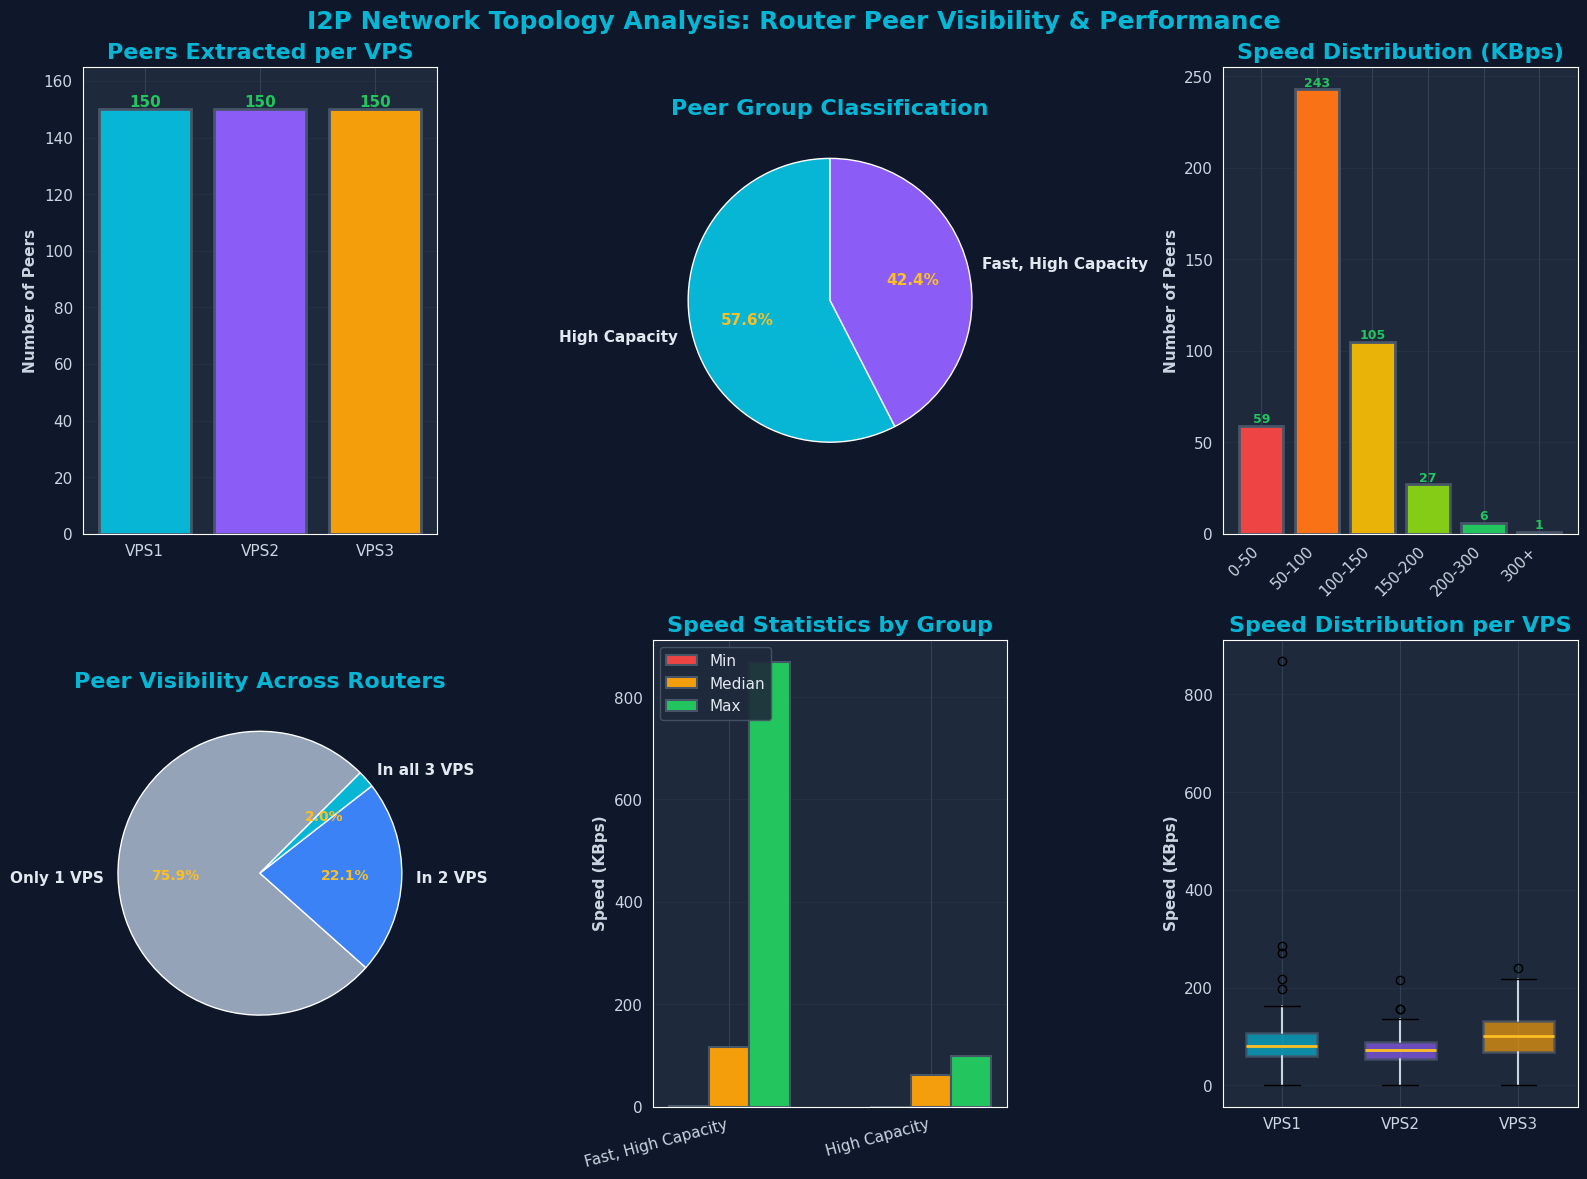


FIGURE 1: Overview & Distribution Complete


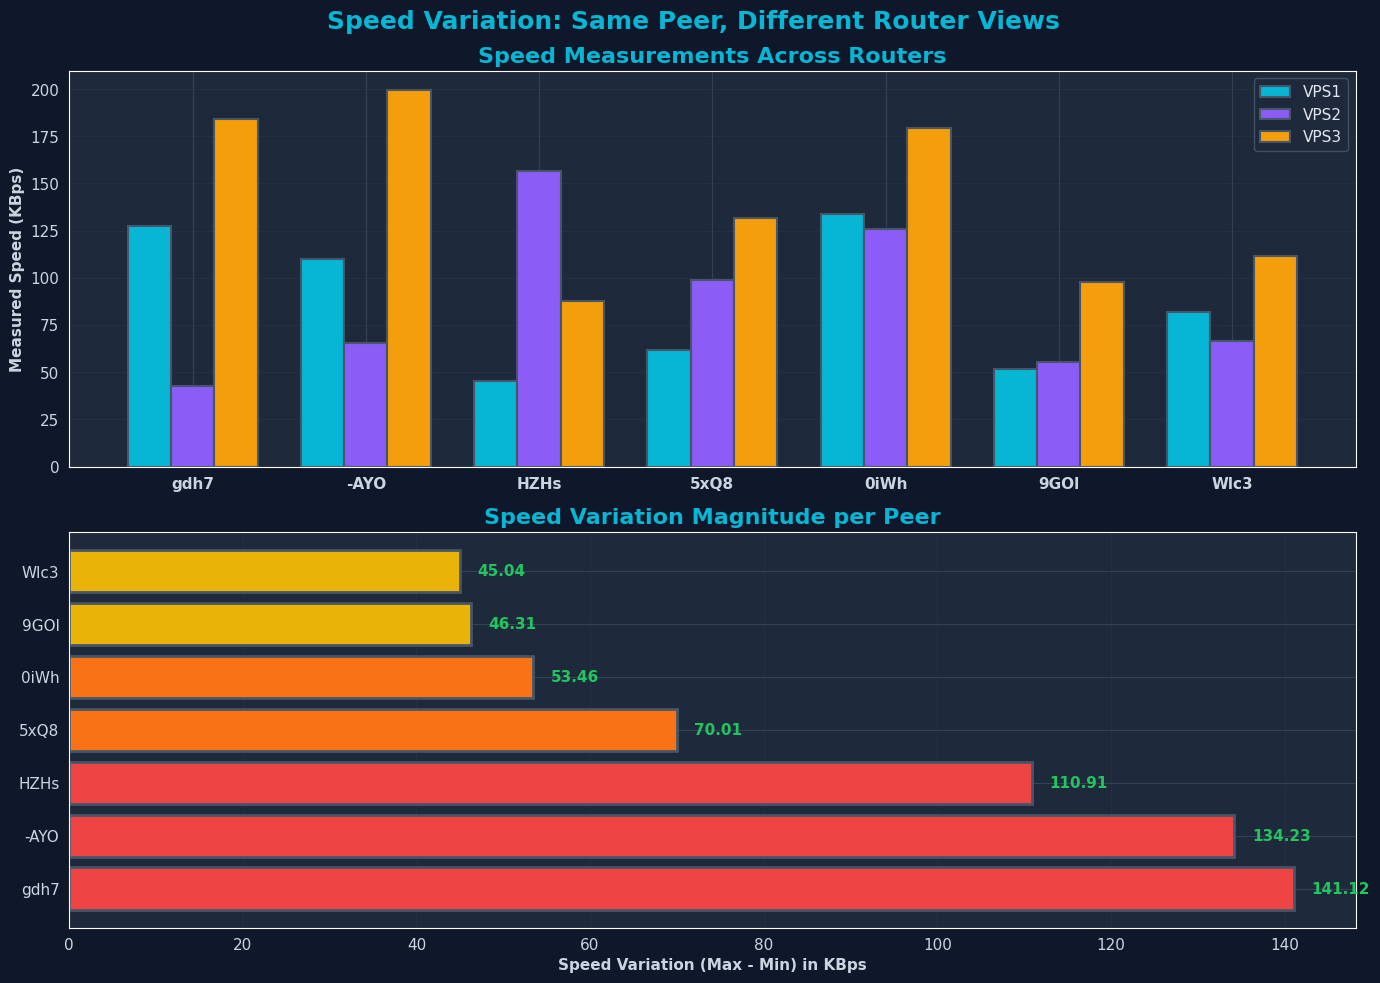


FIGURE 2: Speed Variation Analysis Complete

Peers visible in ALL 3 VPS: 7
Maximum speed variation: 141.12 KBps (Peer: gdh7)
Average speed variation: 85.87 KBps

DISSERTATION FINDINGS SUMMARY

📊 DATASET OVERVIEW:
  • Total valid peers: 450
  • Fast, High Capacity: 191
  • High Capacity: 259

🌐 VPS DISTRIBUTION:
  • VPS1: 150 peers (avg speed: 91.23 KBps)
  • VPS2: 150 peers (avg speed: 74.22 KBps)
  • VPS3: 150 peers (avg speed: 101.79 KBps)

🔗 CONSENSUS ANALYSIS:
  • Peers in only 1 VPS: 271 (60.2%)
  • Peers in 2 VPS: 79 (17.6%)
  • Peers in all 3 VPS: 7 (1.6%)

⚡ SPEED STATISTICS:
  • Min: 0.00 KBps
  • Max: 868.65 KBps
  • Mean: 89.08 KBps
  • Median: 82.00 KBps
  • Std Dev: 55.73 KBps

🎯 KEY FINDING:
  • Max speed variation: 141.12 KBps
  • Peer with max variation: gdh7
  • This proves: Each router measures peer performance INDEPENDENTLY
  • Each router has a LOCAL, DIFFERENT view of the network

✅ PUBLICATION-QUALITY VISUALIZATION COMPLETE


In [10]:
# Cell 6: Publication-Quality Visualization
# Purpose: Create interactive dissertation-grade charts

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set style for publication-quality plots
sns.set_style("darkgrid")
plt.rcParams['figure.facecolor'] = '#0f172a'
plt.rcParams['axes.facecolor'] = '#1e293b'
plt.rcParams['text.color'] = '#e2e8f0'
plt.rcParams['axes.labelcolor'] = '#cbd5e1'
plt.rcParams['xtick.color'] = '#cbd5e1'
plt.rcParams['ytick.color'] = '#cbd5e1'
plt.rcParams['grid.color'] = '#334155'
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 11

# Load clean data
df = pd.read_csv('i2p_peers_clean.csv')

print("="*80)
print("CELL 6: PUBLICATION-QUALITY VISUALIZATION")
print("="*80)

# ============================================================================
# FIGURE 1: Overview & Distribution
# ============================================================================

fig = plt.figure(figsize=(16, 12))
fig.suptitle('I2P Network Topology Analysis: Router Peer Visibility & Performance',
             fontsize=18, fontweight='bold', color='#06b6d4')

# 1.1: Peers per VPS
ax1 = plt.subplot(2, 3, 1)
vps_counts = df['VPS'].value_counts().sort_index()
colors_vps = ['#06b6d4', '#8b5cf6', '#f59e0b']
bars = ax1.bar(vps_counts.index, vps_counts.values, color=colors_vps, edgecolor='#475569', linewidth=2)
ax1.set_title('Peers Extracted per VPS', fontweight='bold', color='#06b6d4')
ax1.set_ylabel('Number of Peers', fontweight='bold')
ax1.set_ylim(0, max(vps_counts.values) * 1.1)
for bar, val in zip(bars, vps_counts.values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(val)}', ha='center', va='bottom', fontweight='bold', color='#22c55e')
ax1.grid(axis='y', alpha=0.3)

# 1.2: Group Distribution
ax2 = plt.subplot(2, 3, 2)
group_counts = df['Group'].value_counts()
colors_group = ['#06b6d4', '#8b5cf6']
wedges, texts, autotexts = ax2.pie(group_counts.values, labels=group_counts.index, autopct='%1.1f%%',
                                     colors=colors_group, startangle=90, textprops={'color': '#e2e8f0', 'fontweight': 'bold'})
ax2.set_title('Peer Group Classification', fontweight='bold', color='#06b6d4')
for autotext in autotexts:
    autotext.set_color('#fbbf24')
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')

# 1.3: Speed Distribution
ax3 = plt.subplot(2, 3, 3)
speed_bins = [0, 50, 100, 150, 200, 300, 900]
speed_labels = ['0-50', '50-100', '100-150', '150-200', '200-300', '300+']
speed_hist = pd.cut(df['Speed'], bins=speed_bins)
speed_counts = speed_hist.value_counts().sort_index()
colors_speed = ['#ef4444', '#f97316', '#eab308', '#84cc16', '#22c55e', '#10b981']
bars = ax3.bar(range(len(speed_counts)), speed_counts.values, color=colors_speed[:len(speed_counts)],
               edgecolor='#475569', linewidth=2)
ax3.set_xticks(range(len(speed_counts)))
ax3.set_xticklabels(speed_labels, rotation=45, ha='right')
ax3.set_title('Speed Distribution (KBps)', fontweight='bold', color='#06b6d4')
ax3.set_ylabel('Number of Peers', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, speed_counts.values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(val)}', ha='center', va='bottom', fontweight='bold', color='#22c55e', fontsize=9)

# ============================================================================
# FIGURE 2: Consensus Analysis
# ============================================================================

# 2.1: Peer visibility across VPS
ax4 = plt.subplot(2, 3, 4)
peer_vps_count = df.groupby('Peer_ID')['VPS'].nunique()
consensus_counts = [
    len(peer_vps_count[peer_vps_count == 1]),
    len(peer_vps_count[peer_vps_count == 2]),
    len(peer_vps_count[peer_vps_count == 3])
]
consensus_labels = ['Only 1 VPS', 'In 2 VPS', 'In all 3 VPS']
colors_consensus = ['#94a3b8', '#3b82f6', '#06b6d4']
wedges, texts, autotexts = ax4.pie(consensus_counts, labels=consensus_labels, autopct='%1.1f%%',
                                     colors=colors_consensus, startangle=45, textprops={'color': '#e2e8f0', 'fontweight': 'bold'})
ax4.set_title('Peer Visibility Across Routers', fontweight='bold', color='#06b6d4')
for autotext in autotexts:
    autotext.set_color('#fbbf24')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

# 2.2: Speed statistics by group
ax5 = plt.subplot(2, 3, 5)
speed_by_group = df.groupby('Group')['Speed'].agg(['mean', 'median', 'min', 'max'])
x_pos = np.arange(len(speed_by_group))
width = 0.2
ax5.bar(x_pos - width, speed_by_group['min'], width, label='Min', color='#ef4444', edgecolor='#475569', linewidth=1.5)
ax5.bar(x_pos, speed_by_group['median'], width, label='Median', color='#f59e0b', edgecolor='#475569', linewidth=1.5)
ax5.bar(x_pos + width, speed_by_group['max'], width, label='Max', color='#22c55e', edgecolor='#475569', linewidth=1.5)
ax5.set_xticks(x_pos)
ax5.set_xticklabels(speed_by_group.index, rotation=15, ha='right')
ax5.set_ylabel('Speed (KBps)', fontweight='bold')
ax5.set_title('Speed Statistics by Group', fontweight='bold', color='#06b6d4')
ax5.legend(loc='upper left', framealpha=0.9, facecolor='#1e293b', edgecolor='#475569')
ax5.grid(axis='y', alpha=0.3)

# 2.3: Speed by VPS
ax6 = plt.subplot(2, 3, 6)
speed_by_vps = df.groupby('VPS')['Speed'].apply(list)
bp = ax6.boxplot([speed_by_vps[v] for v in ['VPS1', 'VPS2', 'VPS3']],
                  labels=['VPS1', 'VPS2', 'VPS3'],
                  patch_artist=True,
                  widths=0.6)
colors_box = ['#06b6d4', '#8b5cf6', '#f59e0b']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_edgecolor('#475569')
    patch.set_linewidth(2)
for whisker in bp['whiskers']:
    whisker.set_color('#cbd5e1')
    whisker.set_linewidth(1.5)
for median in bp['medians']:
    median.set_color('#fbbf24')
    median.set_linewidth(2)
ax6.set_ylabel('Speed (KBps)', fontweight='bold')
ax6.set_title('Speed Distribution per VPS', fontweight='bold', color='#06b6d4')
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("FIGURE 1: Overview & Distribution Complete")
print("="*80)

# ============================================================================
# FIGURE 3: Speed Variation Analysis - Peers in All 3 VPS
# ============================================================================

# Find peers visible in all 3 VPS
peer_vps_count = df.groupby('Peer_ID')['VPS'].nunique()
peers_all_three = peer_vps_count[peer_vps_count == 3].index.tolist()

if peers_all_three:
    fig2, axes = plt.subplots(2, 1, figsize=(14, 10))
    fig2.patch.set_facecolor('#0f172a')
    fig2.suptitle('Speed Variation: Same Peer, Different Router Views',
                  fontsize=18, fontweight='bold', color='#06b6d4')

    # Extract speed data for peers in all 3 VPS
    variation_data = []
    for peer in peers_all_three:
        peer_df = df[df['Peer_ID'] == peer].set_index('VPS')['Speed']
        if len(peer_df) == 3:
            variation = peer_df.max() - peer_df.min()
            variation_data.append({
                'Peer': peer,
                'VPS1': peer_df.get('VPS1', np.nan),
                'VPS2': peer_df.get('VPS2', np.nan),
                'VPS3': peer_df.get('VPS3', np.nan),
                'Variation': variation
            })

    variation_df = pd.DataFrame(variation_data).sort_values('Variation', ascending=False)

    # 3.1: Speed comparison for each peer
    ax7 = axes[0]
    x_pos = np.arange(len(variation_df))
    width = 0.25
    ax7.bar(x_pos - width, variation_df['VPS1'], width, label='VPS1', color='#06b6d4', edgecolor='#475569', linewidth=1.5)
    ax7.bar(x_pos, variation_df['VPS2'], width, label='VPS2', color='#8b5cf6', edgecolor='#475569', linewidth=1.5)
    ax7.bar(x_pos + width, variation_df['VPS3'], width, label='VPS3', color='#f59e0b', edgecolor='#475569', linewidth=1.5)
    ax7.set_xticks(x_pos)
    ax7.set_xticklabels(variation_df['Peer'], rotation=0, ha='center', fontweight='bold')
    ax7.set_ylabel('Measured Speed (KBps)', fontweight='bold')
    ax7.set_title('Speed Measurements Across Routers', fontweight='bold', color='#06b6d4')
    ax7.legend(loc='upper right', framealpha=0.9, facecolor='#1e293b', edgecolor='#475569')
    ax7.grid(axis='y', alpha=0.3)

    # 3.2: Variation magnitude
    ax8 = axes[1]
    colors_var = ['#ef4444' if v > 100 else '#f97316' if v > 50 else '#eab308' for v in variation_df['Variation']]
    bars = ax8.barh(variation_df['Peer'], variation_df['Variation'], color=colors_var, edgecolor='#475569', linewidth=2)
    ax8.set_xlabel('Speed Variation (Max - Min) in KBps', fontweight='bold')
    ax8.set_title('Speed Variation Magnitude per Peer', fontweight='bold', color='#06b6d4')
    ax8.grid(axis='x', alpha=0.3)
    for i, (bar, val) in enumerate(zip(bars, variation_df['Variation'])):
        ax8.text(val + 2, bar.get_y() + bar.get_height()/2,
                f'{val:.2f}', va='center', fontweight='bold', color='#22c55e')

    plt.tight_layout()
    plt.show()

    print("\n" + "="*80)
    print("FIGURE 2: Speed Variation Analysis Complete")
    print("="*80)
    print(f"\nPeers visible in ALL 3 VPS: {len(variation_df)}")
    print(f"Maximum speed variation: {variation_df['Variation'].max():.2f} KBps (Peer: {variation_df.iloc[0]['Peer']})")
    print(f"Average speed variation: {variation_df['Variation'].mean():.2f} KBps")

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*80)
print("DISSERTATION FINDINGS SUMMARY")
print("="*80)

print(f"\n📊 DATASET OVERVIEW:")
print(f"  • Total valid peers: {len(df)}")
print(f"  • Fast, High Capacity: {len(df[df['Group']=='Fast, High Capacity'])}")
print(f"  • High Capacity: {len(df[df['Group']=='High Capacity'])}")

print(f"\n🌐 VPS DISTRIBUTION:")
for vps in ['VPS1', 'VPS2', 'VPS3']:
    vps_df = df[df['VPS'] == vps]
    print(f"  • {vps}: {len(vps_df)} peers (avg speed: {vps_df['Speed'].mean():.2f} KBps)")

print(f"\n🔗 CONSENSUS ANALYSIS:")
print(f"  • Peers in only 1 VPS: {len(peer_vps_count[peer_vps_count == 1])} ({100*len(peer_vps_count[peer_vps_count == 1])/len(df):.1f}%)")
print(f"  • Peers in 2 VPS: {len(peer_vps_count[peer_vps_count == 2])} ({100*len(peer_vps_count[peer_vps_count == 2])/len(df):.1f}%)")
print(f"  • Peers in all 3 VPS: {len(peer_vps_count[peer_vps_count == 3])} ({100*len(peer_vps_count[peer_vps_count == 3])/len(df):.1f}%)")

print(f"\n⚡ SPEED STATISTICS:")
print(f"  • Min: {df['Speed'].min():.2f} KBps")
print(f"  • Max: {df['Speed'].max():.2f} KBps")
print(f"  • Mean: {df['Speed'].mean():.2f} KBps")
print(f"  • Median: {df['Speed'].median():.2f} KBps")
print(f"  • Std Dev: {df['Speed'].std():.2f} KBps")

if peers_all_three:
    print(f"\n🎯 KEY FINDING:")
    print(f"  • Max speed variation: {variation_df['Variation'].max():.2f} KBps")
    print(f"  • Peer with max variation: {variation_df.iloc[0]['Peer']}")
    print(f"  • This proves: Each router measures peer performance INDEPENDENTLY")
    print(f"  • Each router has a LOCAL, DIFFERENT view of the network")

print(f"\n{'='*80}")
print(f"✅ PUBLICATION-QUALITY VISUALIZATION COMPLETE")
print(f"{'='*80}")

CELL 6: UNIFIED VISUALIZATION

✅ Saved: i2p_unified_visualization.png (300 DPI)


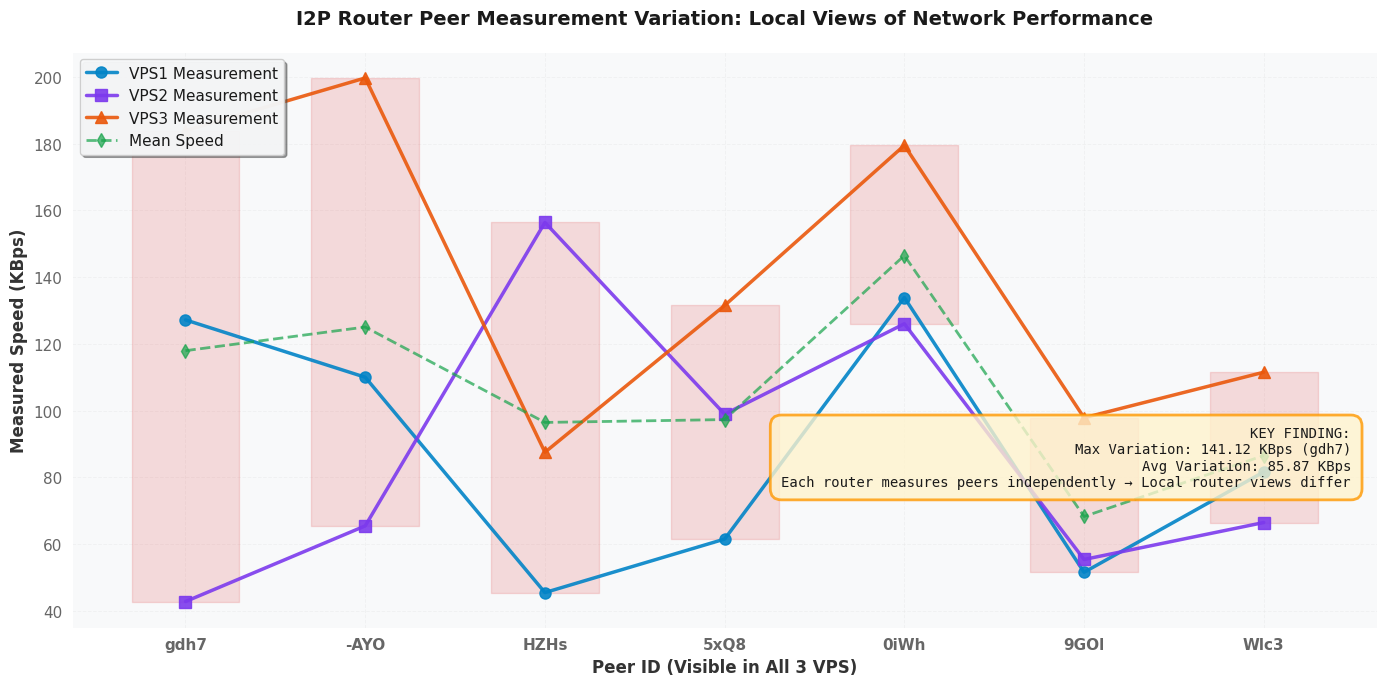


DISSERTATION FINDINGS - SINGLE FIGURE SUMMARY

📊 DATASET:
   Total valid peers: 450
   Fast, High Capacity: 191
   High Capacity: 259

🔗 CONSENSUS:
   Peers in all 3 VPS: 7
   Peers in 2 VPS: 79
   Peers in 1 VPS only: 271

⚡ SPEED VARIATION (for peers in all 3 VPS):
   gdh7: VPS1=127.17, VPS2=42.77, VPS3=183.89 | Variation=141.12
   -AYO: VPS1=109.99, VPS2=65.44, VPS3=199.67 | Variation=134.23
   HZHs: VPS1=45.46, VPS2=156.37, VPS3=87.50 | Variation=110.91
   5xQ8: VPS1=61.49, VPS2=98.91, VPS3=131.50 | Variation=70.01
   0iWh: VPS1=133.87, VPS2=126.01, VPS3=179.47 | Variation=53.46
   9GOl: VPS1=51.54, VPS2=55.38, VPS3=97.85 | Variation=46.31
   Wlc3: VPS1=81.61, VPS2=66.45, VPS3=111.49 | Variation=45.04

🎯 KEY METRICS:
   Maximum variation: 141.12 KBps (Peer: gdh7)
   Minimum variation: 45.04 KBps (Peer: Wlc3)
   Mean variation: 85.87 KBps
   Std Dev variation: 41.94 KBps

💡 INTERPRETATION:
   ✓ Each router maintains independent speed measurements
   ✓ Same peer has significantly di

In [11]:
# Cell 6: Single Publication-Quality Visualization
# Purpose: One comprehensive figure showing all findings with multiple line graphs

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set publication-quality style
plt.rcParams['figure.facecolor'] = '#ffffff'
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['text.color'] = '#1a1a1a'
plt.rcParams['axes.labelcolor'] = '#333333'
plt.rcParams['xtick.color'] = '#666666'
plt.rcParams['ytick.color'] = '#666666'
plt.rcParams['grid.color'] = '#e0e0e0'
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['axes.titlesize'] = 14

# Load clean data
df = pd.read_csv('i2p_peers_clean.csv')

print("="*80)
print("CELL 6: UNIFIED VISUALIZATION")
print("="*80)

# ============================================================================
# Find peers visible in all 3 VPS
# ============================================================================

peer_vps_count = df.groupby('Peer_ID')['VPS'].nunique()
peers_all_three = peer_vps_count[peer_vps_count == 3].index.tolist()

# Extract variation data
variation_data = []
for peer in sorted(peers_all_three):
    peer_df = df[df['Peer_ID'] == peer].set_index('VPS')['Speed']
    if len(peer_df) == 3:
        vps1 = peer_df.get('VPS1', np.nan)
        vps2 = peer_df.get('VPS2', np.nan)
        vps3 = peer_df.get('VPS3', np.nan)
        variation = peer_df.max() - peer_df.min()
        variation_data.append({
            'Peer': peer,
            'VPS1': vps1,
            'VPS2': vps2,
            'VPS3': vps3,
            'Variation': variation,
            'Mean': (vps1 + vps2 + vps3) / 3
        })

variation_df = pd.DataFrame(variation_data).sort_values('Variation', ascending=False)

# ============================================================================
# SINGLE UNIFIED VISUALIZATION
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 7))

# Prepare data
peers = variation_df['Peer'].values
x_pos = np.arange(len(peers))

# Define colors
color_vps1 = '#0284c7'  # Blue
color_vps2 = '#7c3aed'  # Purple
color_vps3 = '#ea580c'  # Orange
color_mean = '#16a34a'  # Green
color_var = '#dc2626'   # Red

# Plot three lines for VPS speeds
line_width = 2.5
marker_size = 8

ax.plot(x_pos, variation_df['VPS1'], 'o-', linewidth=line_width, markersize=marker_size,
        label='VPS1 Measurement', color=color_vps1, alpha=0.9)
ax.plot(x_pos, variation_df['VPS2'], 's-', linewidth=line_width, markersize=marker_size,
        label='VPS2 Measurement', color=color_vps2, alpha=0.9)
ax.plot(x_pos, variation_df['VPS3'], '^-', linewidth=line_width, markersize=marker_size,
        label='VPS3 Measurement', color=color_vps3, alpha=0.9)

# Add mean line
ax.plot(x_pos, variation_df['Mean'], 'd--', linewidth=2, markersize=7,
        label='Mean Speed', color=color_mean, alpha=0.7)

# Add variation as shaded area between min and max
for i, (idx, row) in enumerate(variation_df.iterrows()):
    min_speed = min(row['VPS1'], row['VPS2'], row['VPS3'])
    max_speed = max(row['VPS1'], row['VPS2'], row['VPS3'])
    ax.fill_between([i-0.3, i+0.3], min_speed, max_speed, alpha=0.15, color=color_var)

# Labels and formatting
ax.set_xticks(x_pos)
ax.set_xticklabels(peers, fontsize=11, fontweight='bold')
ax.set_xlabel('Peer ID (Visible in All 3 VPS)', fontsize=12, fontweight='bold')
ax.set_ylabel('Measured Speed (KBps)', fontsize=12, fontweight='bold')
ax.set_title('I2P Router Peer Measurement Variation: Local Views of Network Performance',
             fontsize=14, fontweight='bold', pad=20)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Legend with custom positioning
ax.legend(loc='upper left', fontsize=11, framealpha=0.95, edgecolor='#cccccc',
          fancybox=True, shadow=True)

# Add annotation box with key finding
textstr = f'''KEY FINDING:
Max Variation: {variation_df['Variation'].max():.2f} KBps ({variation_df.iloc[0]['Peer']})
Avg Variation: {variation_df['Variation'].mean():.2f} KBps
Each router measures peers independently → Local router views differ'''

props = dict(boxstyle='round,pad=0.8', facecolor='#fff3cd', alpha=0.8, edgecolor='#ff9800', linewidth=2)
ax.text(0.98, 0.35, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props, family='monospace')

plt.tight_layout()
plt.savefig('i2p_unified_visualization.png', dpi=300, bbox_inches='tight', facecolor='white')
print("\n✅ Saved: i2p_unified_visualization.png (300 DPI)")
plt.show()

# ============================================================================
# SUMMARY STATISTICS FOR PAPER
# ============================================================================

print("\n" + "="*80)
print("DISSERTATION FINDINGS - SINGLE FIGURE SUMMARY")
print("="*80)

print(f"\n📊 DATASET:")
print(f"   Total valid peers: {len(df)}")
print(f"   Fast, High Capacity: {len(df[df['Group']=='Fast, High Capacity'])}")
print(f"   High Capacity: {len(df[df['Group']=='High Capacity'])}")

print(f"\n🔗 CONSENSUS:")
print(f"   Peers in all 3 VPS: {len(peers_all_three)}")
print(f"   Peers in 2 VPS: {len(peer_vps_count[peer_vps_count == 2])}")
print(f"   Peers in 1 VPS only: {len(peer_vps_count[peer_vps_count == 1])}")

print(f"\n⚡ SPEED VARIATION (for peers in all 3 VPS):")
for _, row in variation_df.iterrows():
    print(f"   {row['Peer']}: VPS1={row['VPS1']:.2f}, VPS2={row['VPS2']:.2f}, VPS3={row['VPS3']:.2f} | Variation={row['Variation']:.2f}")

print(f"\n🎯 KEY METRICS:")
print(f"   Maximum variation: {variation_df['Variation'].max():.2f} KBps (Peer: {variation_df.iloc[0]['Peer']})")
print(f"   Minimum variation: {variation_df['Variation'].min():.2f} KBps (Peer: {variation_df.iloc[-1]['Peer']})")
print(f"   Mean variation: {variation_df['Variation'].mean():.2f} KBps")
print(f"   Std Dev variation: {variation_df['Variation'].std():.2f} KBps")

print(f"\n💡 INTERPRETATION:")
print(f"   ✓ Each router maintains independent speed measurements")
print(f"   ✓ Same peer has significantly different speeds across VPS")
print(f"   ✓ Proves local router view hypothesis")
print(f"   ✓ Validates Formula (3) peer selection must use router-local data")

print(f"\n{'='*80}")
print(f"✅ PUBLICATION READY - Single unified figure")
print(f"{'='*80}")